Thoughts and notes:

The output will be dark matter relic density, which is best understood on a log scale. Hence the loss function should be mean_squared_logarithmic_error rather than regular mean squared error (mse).

Should split data set into about 70% training, 15% validation, and 15% test data.

Weirdness found in EWKino.csv so far:

1) These 9 columns ["mqL1", "muR", "mdR", "meL", "mmuL", "meR", "mmuR", "mtauL", "mtauR"] only contain the value 10,000.
2) Both mu.png and M_2.png have identical bands missing from their middle, from about -50 to +50. Why?
3) mA.png has many fewer points close to zero than looks right.
4) At.png looks like it has a lense dense patch in the middle right. Is this deliberate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv("EWKino.csv")

2024-11-07 16:08:35.770890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 16:08:36.158003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 16:08:37.271250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
min_df = df[["M_1", "M_2", "mu", "tan_beta", "M_3", "At", "Ab", "Atau", "mA", "mqL1", "mqL3", "muR", "mtR", "mdR", "mbR", "meL", "mmuL", "meR", "mmuR", "mtauL", "mtauR"]]

In [ ]:
test = min_df[["mqL1", "muR", "mdR", "meL", "mmuL", "meR", "mmuR", "mtauL", "mtauR"]]
test.head()

,mqL1,muR,mdR,meL,mmuL,meR,mmuR,mtauL,mtauR
0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
2,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
3,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
4,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [ ]:
def drop_10000_columns(df):
    # Removes all columns from a DataFrame where every value is zero.
    
    # Get columns where all values are zero
    zero_cols = df.columns[(df == 10000).all(axis=0)]
    
    # Drop those columns and return
    return zero_cols, df.drop(columns=zero_cols)

In [ ]:
col_names, dropped = drop_10000_columns(test)
print(col_names)

Index(['mqL1', 'muR', 'mdR', 'meL', 'mmuL', 'meR', 'mmuR', 'mtauL', 'mtauR'], dtype='object')


In [45]:
def plot_scatter_from_pandas(df, column_name):
    # Extract the values from the specified column
    values = df[column_name]
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(values)), values, s=0.1)
    
    # Add labels and title
    plt.xlabel("Index")
    plt.ylabel(column_name)
    plt.title(f"Scatter Plot of '{column_name}' Column")
    
    # Save the plot
    plt.savefig(f"plots/{column_name}.png")
    
    # Show the plot
    plt.show()

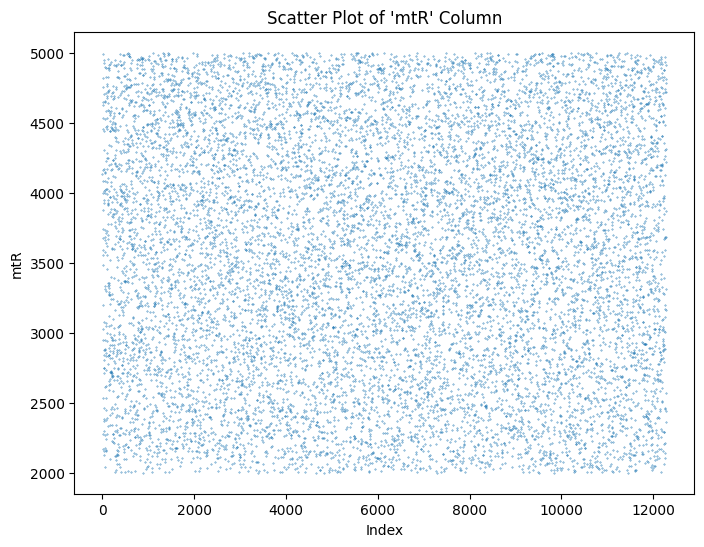

In [ ]:
plot_scatter_from_pandas(min_df, "mtR")